In [3]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [4]:
import torch

In [5]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [4]:
niter = 3
ibatch = 0

# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
# load true continuum
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

# load SpenderQ recon wavelength
w_recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i.wave_recon.npy' % niter)

In [7]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


# what fraction of spectral elements have absorption? 

In [7]:
dspec, dspec_lya, dspec_lyb = [], [], []
for igal in range(len(spec)): 
    snr = np.array(spec)[igal] * np.array(w)[igal]**-0.5
    
    wlim = np.array(models[0].wave_obs) < 1215 * (1+np.array(z)[igal])
    
    dw = np.clip(8.0 / np.median(snr[wlim]), 4.0, 16.)

    if dw == 0.: continue
    w_rebin = np.linspace(3600, 9824., int((9824.-3600.)/dw))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=w_rebin[1:-1])
    spec_rebin = U.trapz_rebin(
        np.array(models[0].wave_obs), 
        np.array(spec[igal]), 
        xnew=w_rebin[1:-1])
    ivar_rebin = U.trapz_rebin(
        np.array(models[0].wave_obs), 
        np.array(w[igal]/np.gradient(np.array(models[0].wave_obs))), 
        xnew=w_rebin[1:-1]) * dw

    wlim = (w_rebin[1:-1] > 1215 * (1 + np.array(z)[igal]))
    dspec.append(((true_rebin - spec_rebin) * ivar_rebin**0.5)[wlim])
    
    wlim = (w_rebin[1:-1] > 1026 * (1 + np.array(z)[igal])) & (w_rebin[1:-1] < 1215 * (1 + np.array(z)[igal]))
    dspec_lya.append(((true_rebin - spec_rebin) * ivar_rebin**0.5)[wlim])
    
    wlim = (w_rebin[1:-1] < 1026 * (1 + np.array(z)[igal]))
    dspec_lyb.append(((true_rebin - spec_rebin) * ivar_rebin**0.5)[wlim])    

dspec = np.concatenate(dspec)
dspec_lya = np.concatenate(dspec_lya)
dspec_lyb = np.concatenate(dspec_lyb)

/tmp/ipykernel_1102885/261204684.py:3: RuntimeWarning: divide by zero encountered in power
  snr = np.array(spec)[igal] * np.array(w)[igal]**-0.5
/tmp/ipykernel_1102885/261204684.py:23: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  np.array(w[igal]/np.gradient(np.array(models[0].wave_obs))),
/tmp/ipykernel_1102885/261204684.py:3: RuntimeWarning: divide by zero encountered in power
  snr = np.array(spec)[igal] * np.array(w)[igal]**-0.5


0.23635622887731322


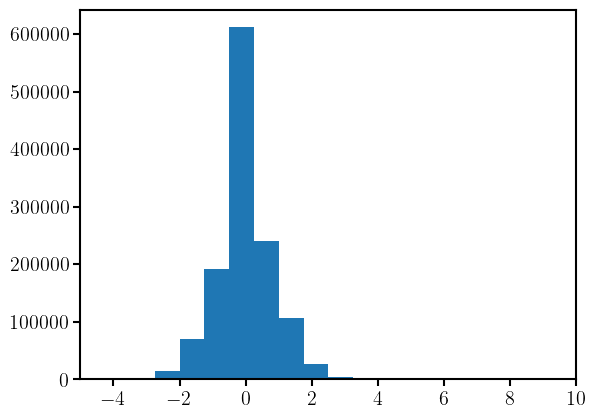

In [8]:
plt.hist(dspec, range=(-5, 10), bins=20)
plt.xlim(-5, 10)
print(1. - 2.*np.mean(dspec < 0))

0.4261480438336651


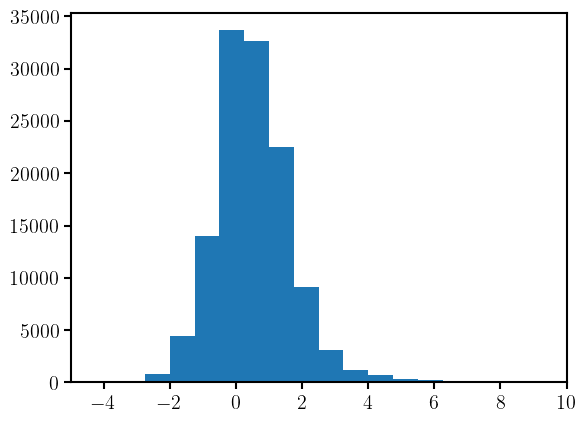

In [9]:
plt.hist(dspec_lya, range=(-5, 10), bins=20)
plt.xlim(-5, 10)
print(1. - 2.*np.mean(dspec_lya < 0))

0.46836010878403


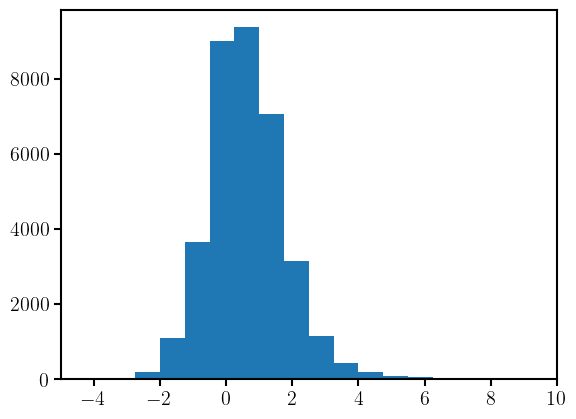

In [10]:
plt.hist(dspec_lyb, range=(-5, 10), bins=20)
plt.xlim(-5, 10)
print(1. - 2.*np.mean(dspec_lyb < 0))

# masking fraction with iterative approach

In [6]:
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

wave_obs = np.array(models[0].wave_obs)

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [7]:
def masking(weights, redshifts, rng):
    if rng == 'above': # above lya
        wlim = np.tile(wave_obs, (len(spec),1)) >  1215 * (1+np.array(redshifts))[:,None]
    elif rng == 'lya': # lya range
        wlim = (np.tile(wave_obs, (len(spec),1)) < 1215 * (1+np.array(redshifts))[:,None]) & (np.tile(wave_obs, (len(spec),1)) > 1026 * (1+np.array(redshifts))[:,None])
    elif rng == 'lyb': # lyb range
        wlim = (np.tile(wave_obs, (len(spec),1)) < 1026 * (1+np.array(redshifts))[:,None])
    val = np.mean(weights[wlim] == 0)
    
    del wlim 
    return val

In [10]:
ibatch = 0
# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % (ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    recon = models[0].decode(s)


for igal in np.arange(spec.shape[0]):
    # identify LyA absorption
    is_absorb = LyA.identify_absorp(
        np.array(models[0].wave_obs),
        np.array(spec[igal]),
        np.array(w[igal]),
        np.array(z)[igal],
        np.array(models[0].wave_rest * (1 + z[igal])),
        np.array(recon[igal]), sigma_lya=0., sigma_lyb=0.)

    # update weights
    w[igal,is_absorb] = 0.
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
print()
"""
for niter in range(4): 
    # load batch
    #with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    #    spec, w, z, target_id, norm, zerr = pickle.load(f)

    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
    models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)

    with torch.no_grad():
        models[0].eval()

        s = models[0].encode(spec)
        recon = models[0].decode(s)


    for igal in np.arange(spec.shape[0]):
        # identify LyA absorption
        is_absorb = LyA.identify_absorp(
            np.array(models[0].wave_obs),
            np.array(spec[igal]),
            np.array(w[igal]),
            np.array(z)[igal],
            np.array(models[0].wave_rest * (1 + z[igal])),
            np.array(recon[igal]), sigma_lya=0, sigma_lyb=0)
        
        # update weights
        w[igal,is_absorb] = 0.
    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
    print()"""

0.2812743318548717 0.0 0.0
0.2829553968001037 0.4507270812593151 0.4776567999146799



'\nfor niter in range(4): \n    # load batch\n    #with open(\'/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl\' % (niter, ibatch), "rb") as f:\n    #    spec, w, z, target_id, norm, zerr = pickle.load(f)\n\n    print(masking(np.array(w), np.array(z), \'above\'), masking(np.array(w), np.array(z), \'lya\'), masking(np.array(w), np.array(z), \'lyb\'))\n    models, losses = load_model(\'/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt\' % niter)\n\n    with torch.no_grad():\n        models[0].eval()\n\n        s = models[0].encode(spec)\n        recon = models[0].decode(s)\n\n\n    for igal in np.arange(spec.shape[0]):\n        # identify LyA absorption\n        is_absorb = LyA.identify_absorp(\n            np.array(models[0].wave_obs),\n            np.array(spec[igal]),\n            np.array(w[igal]),\n            np.array(z)[igal],\n            np.array(models[0].wave_rest * (1 + z[igal])),\n            np.array(recon[igal]), sigma_lya=0, si

In [7]:
# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % (ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    recon = models[0].decode(s)


for igal in np.arange(spec.shape[0]):
    # identify LyA absorption
    is_absorb = LyA.identify_absorp(
        np.array(models[0].wave_obs),
        np.array(spec[igal]),
        np.array(w[igal]),
        np.array(z)[igal],
        np.array(models[0].wave_rest * (1 + z[igal])),
        np.array(recon[igal]), sigma_lya=1., sigma_lyb=1.)

    # update weights
    w[igal,is_absorb] = 0.
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
print()

for niter in range(4): 
    # load batch
    #with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    #    spec, w, z, target_id, norm, zerr = pickle.load(f)

    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))    
    
    models, losses = load_model('/tigress/chhahn/spender_qso/models/london.rebin.sigma1.iter%i.pt' % niter)

    with torch.no_grad():
        models[0].eval()

        s = models[0].encode(spec)
        recon = models[0].decode(s)


    for igal in np.arange(spec.shape[0]):
        # identify LyA absorption
        is_absorb = LyA.identify_absorp(
            np.array(models[0].wave_obs),
            np.array(spec[igal]),
            np.array(w[igal]),
            np.array(z)[igal],
            np.array(models[0].wave_rest * (1 + z[igal])),
            np.array(recon[igal]), sigma_lya=1., sigma_lyb=1.)

        # update weights
        w[igal,is_absorb] = 0.
    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
    print()

0.2812743318548717 0.0 0.0
0.28292879184937525 0.18458138879138206 0.1775288197709931

0.28292879184937525 0.18458138879138206 0.1775288197709931
0.2838019436897727 0.29342202938248446 0.26482679051007846

0.2838019436897727 0.29342202938248446 0.26482679051007846
0.2840004902103687 0.33729290987875266 0.30915930619249377

0.2840004902103687 0.33729290987875266 0.30915930619249377
0.28433630695546813 0.38048907507898055 0.3473012671973318

0.28433630695546813 0.38048907507898055 0.3473012671973318
0.2847059459517596 0.4033402003717408 0.36327939422731986



In [8]:
# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % (ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    recon = models[0].decode(s)


for igal in np.arange(spec.shape[0]):
    # identify LyA absorption
    is_absorb = LyA.identify_absorp(
        np.array(models[0].wave_obs),
        np.array(spec[igal]),
        np.array(w[igal]),
        np.array(z)[igal],
        np.array(models[0].wave_rest * (1 + z[igal])),
        np.array(recon[igal]), sigma_lya=1.5, sigma_lyb=1.2,
        method='snr_rebin')

    # update weights
    w[igal,is_absorb] = 0.
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
print()

for niter in range(4): 
    # load batch
    #with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    #    spec, w, z, target_id, norm, zerr = pickle.load(f)

    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))    
    
    models, losses = load_model('/tigress/chhahn/spender_qso/models/london.rebin.sigma1.iter%i.pt' % niter)

    with torch.no_grad():
        models[0].eval()

        s = models[0].encode(spec)
        recon = models[0].decode(s)


    for igal in np.arange(spec.shape[0]):
        # identify LyA absorption
        is_absorb = LyA.identify_absorp(
            np.array(models[0].wave_obs),
            np.array(spec[igal]),
            np.array(w[igal]),
            np.array(z)[igal],
            np.array(models[0].wave_rest * (1 + z[igal])),
            np.array(recon[igal]), sigma_lya=1.5, sigma_lyb=1.2,
            method='snr_rebin')

        # update weights
        w[igal,is_absorb] = 0.
    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
    print()

0.2812743318548717 0.0 0.0
0.2834099452136137 0.11461959868106826 0.14650333039237548

0.2834099452136137 0.11461959868106826 0.14650333039237548


/home/chhahn/projects/SpenderQ/src/spenderq/lyalpha.py:105: RuntimeWarning: divide by zero encountered in scalar divide
  dw = np.clip(8.0 / np.median(snr[wobs < wmax]), 4.0, 16.)


0.28486246231083245 0.23770982350944025 0.26488496330266337

0.28486246231083245 0.23770982350944025 0.26488496330266337
0.2854145150384484 0.3102668937776576 0.3476648471509875

0.2854145150384484 0.3102668937776576 0.3476648471509875
0.28652739446679293 0.38311456636954255 0.4304738173956041

0.28652739446679293 0.38311456636954255 0.4304738173956041
0.28775560918685933 0.4345785115406527 0.4689890538195286



In [2]:
ibatch = 0
# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % (ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)

print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    recon = models[0].decode(s)


for igal in np.arange(spec.shape[0]):
    # identify LyA absorption
    is_absorb = LyA.identify_LyA(
        np.array(models[0].wave_obs),
        np.array(spec[igal]),
        np.array(w[igal]),
        np.array(z)[igal],
        np.array(models[0].wave_rest * (1 + z[igal])),
        np.array(recon[igal]), sigma=1., method='snr_rebin')

    # update weights
    w[igal,is_absorb] = 0.
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
print()

for niter in range(4): 
    # load batch
    #with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    #    spec, w, z, target_id, norm, zerr = pickle.load(f)

    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))    
    
    models, losses = load_model('/tigress/chhahn/spender_qso/models/london.rebin.sigma1.iter%i.pt' % niter)

    with torch.no_grad():
        models[0].eval()

        s = models[0].encode(spec)
        recon = models[0].decode(s)


    for igal in np.arange(spec.shape[0]):
        # identify LyA absorption
        is_absorb = LyA.identify_LyA(
            np.array(models[0].wave_obs),
            np.array(spec[igal]),
            np.array(w[igal]),
            np.array(z)[igal],
            np.array(models[0].wave_rest * (1 + z[igal])),
            np.array(recon[igal]), sigma=1., method='snr_rebin')

        # update weights
        w[igal,is_absorb] = 0.
    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))
    print()

NameError: name 'pickle' is not defined

In [6]:
ibatch = 3

# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p5sb1p5.i0_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p5sb1p5.i1_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p5sb1p5.i2_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p5sb1p5.i3_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa1p5sb1p5.i4_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

0.2830582384623929 0.0 0.0
0.28499961548430464 0.1274356808848552 0.11472572720611703
0.28676696355076037 0.2091772488710549 0.17481266379275467
0.28767370852570984 0.26959222517253817 0.22824674886834095
0.28818454474765803 0.31567060098443184 0.2852410085363277
0.2886755855319561 0.3444944661993772 0.32658308647358414


In [27]:
for ibatch in range(5): 
    # load batch
    with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % ibatch, "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

    with open('/tigress/chhahn/spender_qso/train/london.lfsc.rsnr.sa0sb0.i0_%i.pkl' % ibatch, "rb") as f:
        spec, w, z, target_id, norm, zerr = pickle.load(f)
    print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))


0.2812743318548717 0.0 0.0
0.2834245213302362 0.4415241948013834 0.4720237344993746
0.28112597829473857 0.0 0.0
0.28325028150306014 0.43599199120580506 0.4718598695530391
0.28123079221806796 0.0 0.0
0.28364651568713345 0.42939752345577226 0.4552993163334071
0.2830582384623929 0.0 0.0
0.2850161354178831 0.4365281984013004 0.46568162509383665
0.28126071929512747 0.0 0.0
0.2833887293298028 0.44298156424822716 0.4643299127930774


In [26]:
ibatch = 3

# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.rebin.sigma1.iter0_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.rebin.sigma1.iter1_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.rebin.sigma1.iter2_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.rebin.sigma1.iter3_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

with open('/tigress/chhahn/spender_qso/train/london.rebin.sigma1.iter4_%i.pkl' % ibatch, "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

0.2830582384623929 0.0 0.0
0.2846780464324064 0.1942283157535354 0.19028503872588903
0.28621710610639406 0.3143685302496465 0.2845442571956433
0.2863195012119365 0.36427709502766553 0.33463393583594425
0.2864976601507871 0.41066785723665206 0.3762996660088735
0.2872634160374376 0.4478141936768017 0.4066016065737365


In [40]:
ibatch = 0
# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.pkl' % (ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
print(masking(np.array(w), np.array(z), 'above'), masking(np.array(w), np.array(z), 'lya'), masking(np.array(w), np.array(z), 'lyb'))

models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.pt')

with torch.no_grad():
    models[0].eval()

    s = models[0].encode(spec)
    recon = models[0].decode(s)

w1 = np.array(w).copy()
for igal in np.arange(spec.shape[0]):
    # identify LyA absorption
    is_absorb = LyA.identify_absorp(
        np.array(models[0].wave_obs),
        np.array(spec[igal]),
        np.array(w[igal]),
        np.array(z)[igal],
        np.array(models[0].wave_rest * (1 + z[igal])),
        np.array(recon[igal]), sigma_lya=0., sigma_lyb=0.)

    # update weights
    w1[igal,is_absorb] = 0.
print(masking(np.array(w1), np.array(z), 'above'), masking(np.array(w1), np.array(z), 'lya'), masking(np.array(w1), np.array(z), 'lyb'))
print()

0.2812743318548717 0.0 0.0


/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)
/home/chha

0.2829553968001037 0.4507270812593151 0.4776567999146799



In [41]:
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

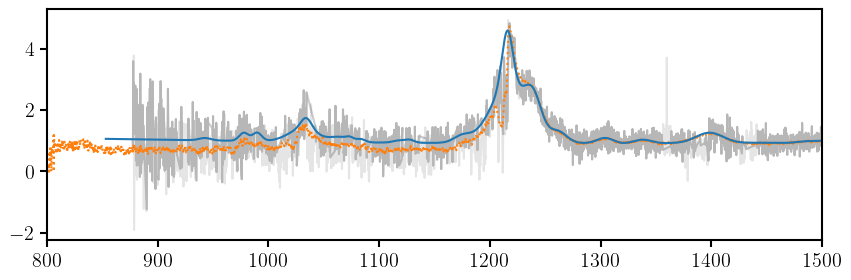

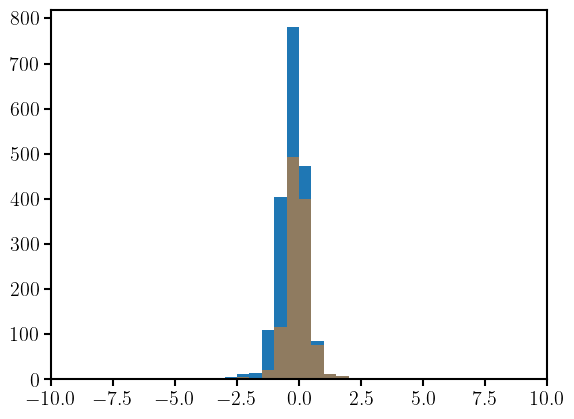

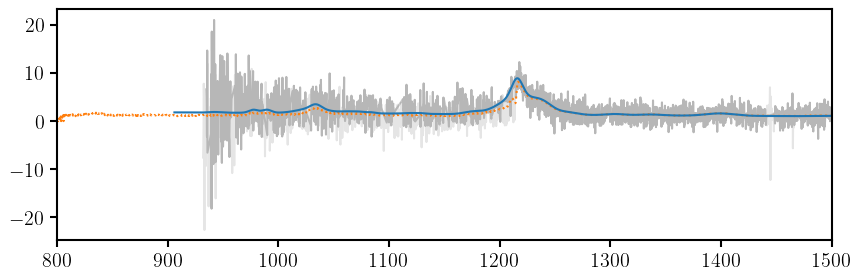

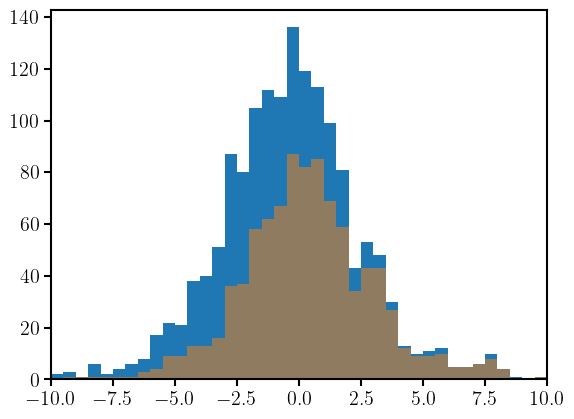

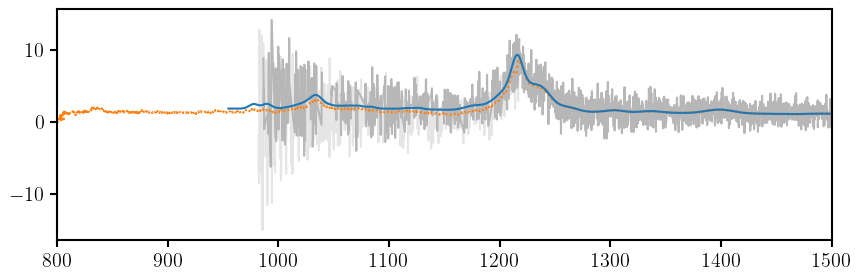

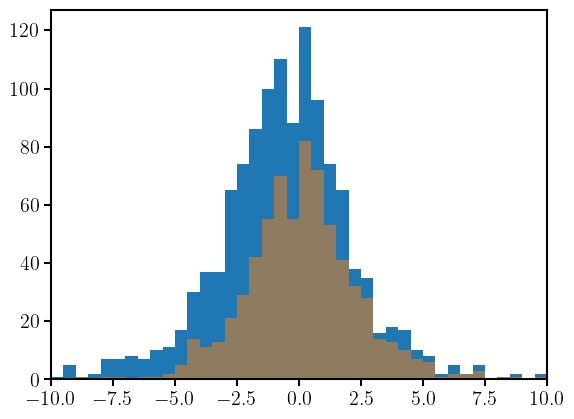

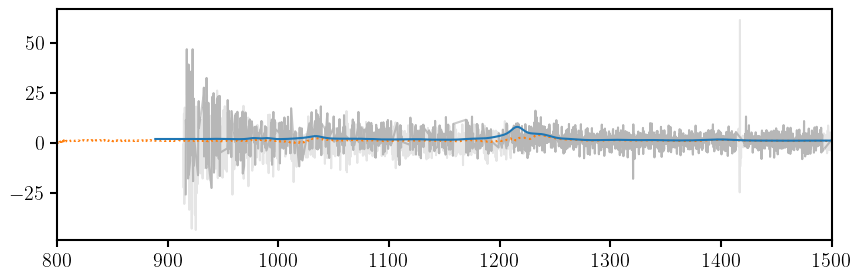

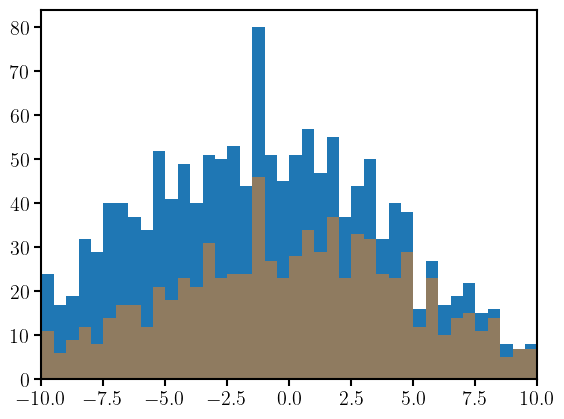

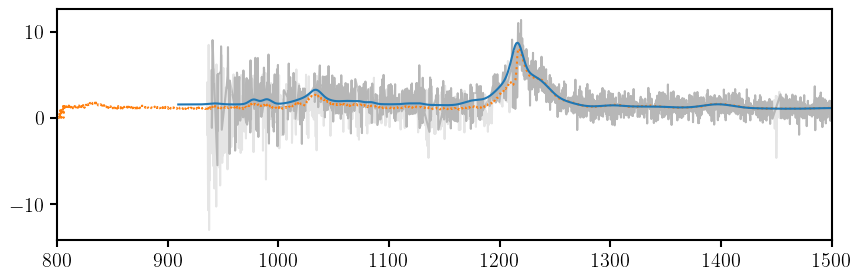

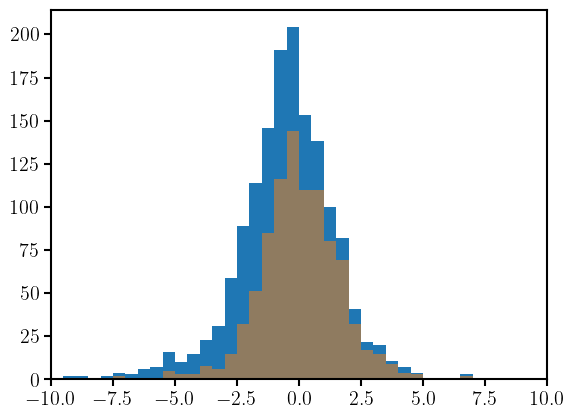

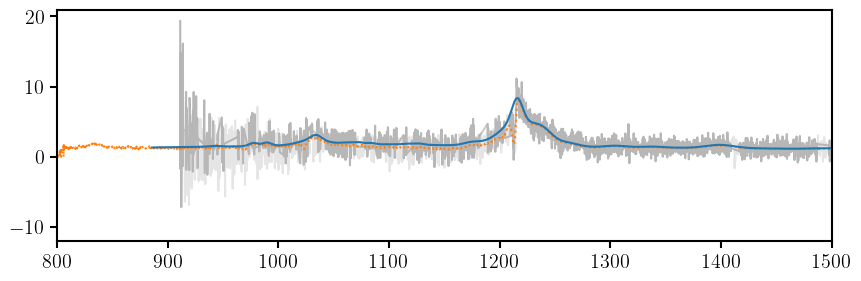

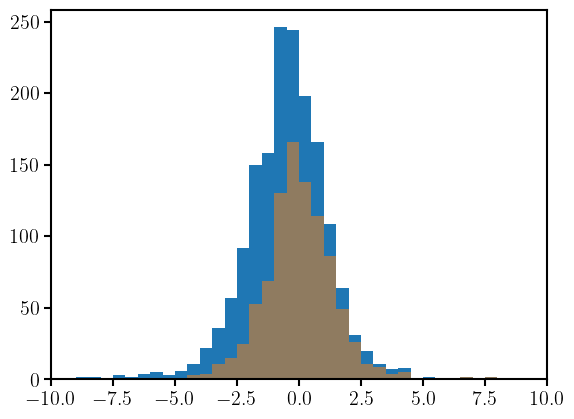

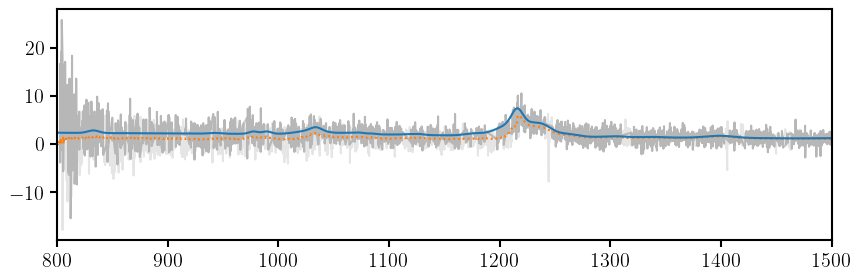

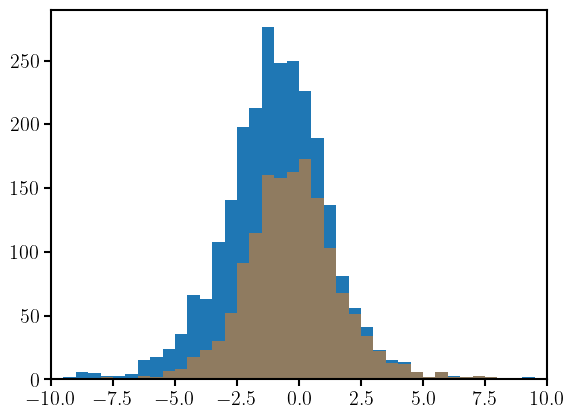

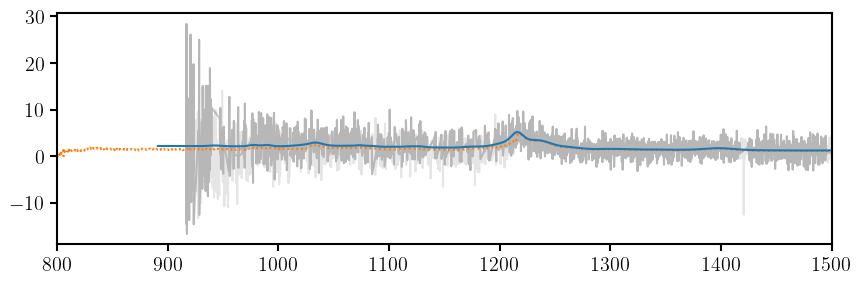

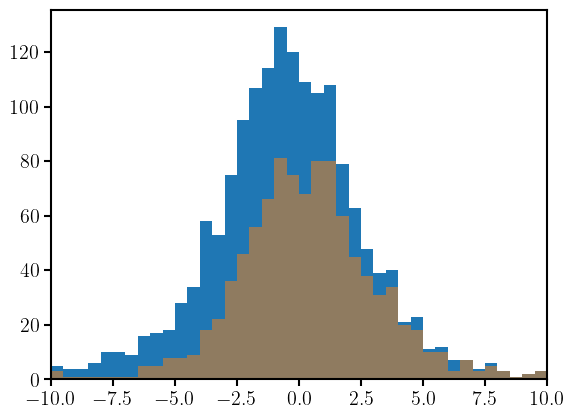

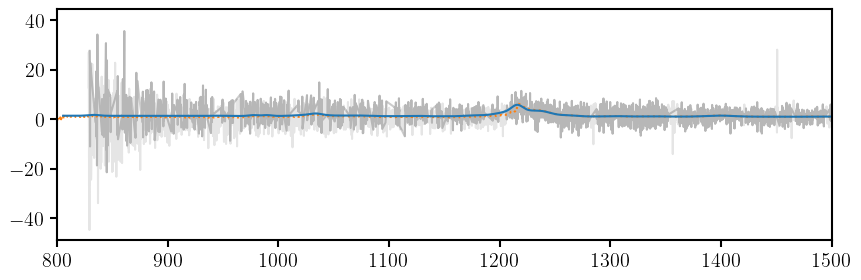

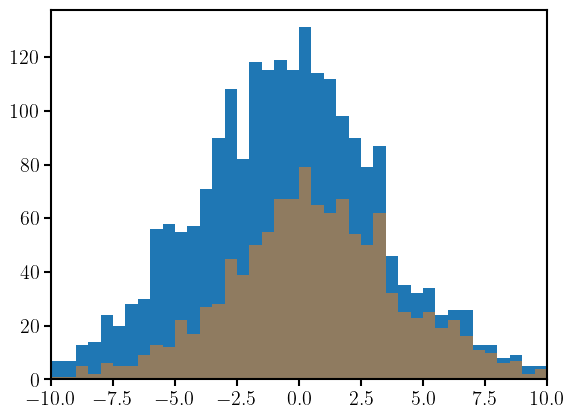

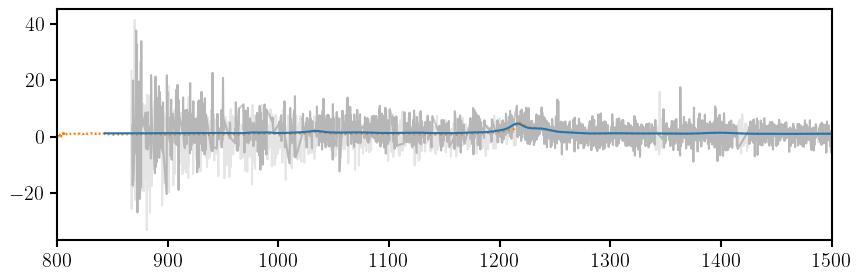

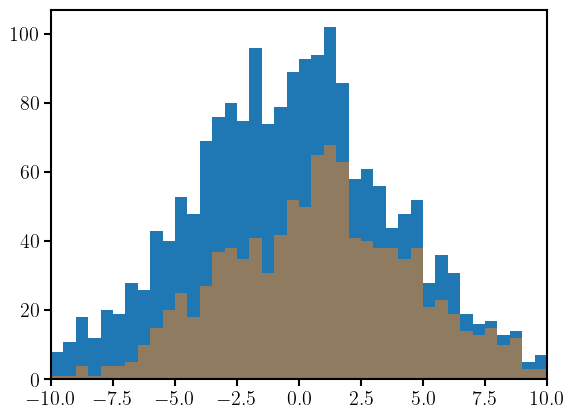

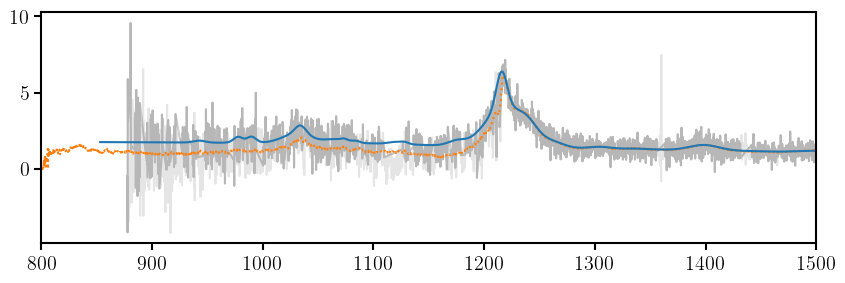

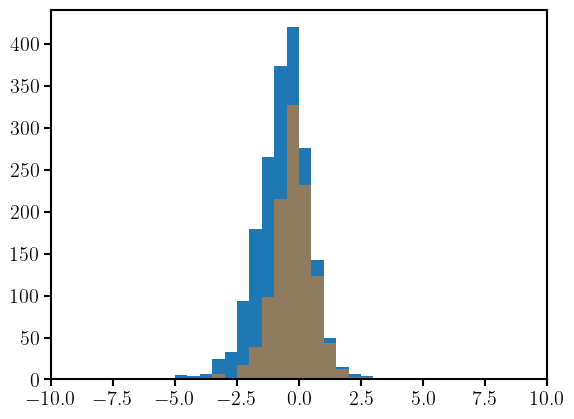

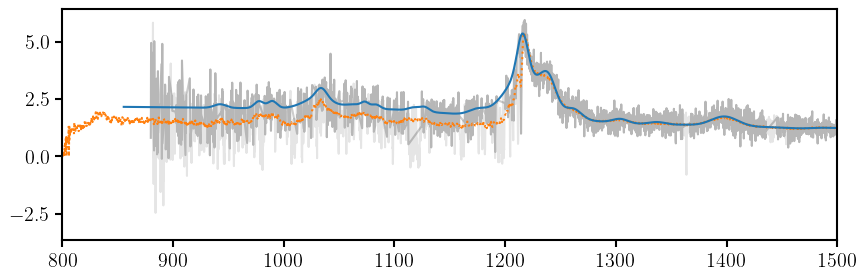

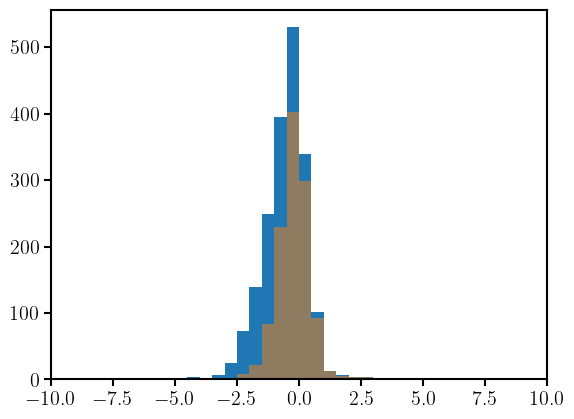

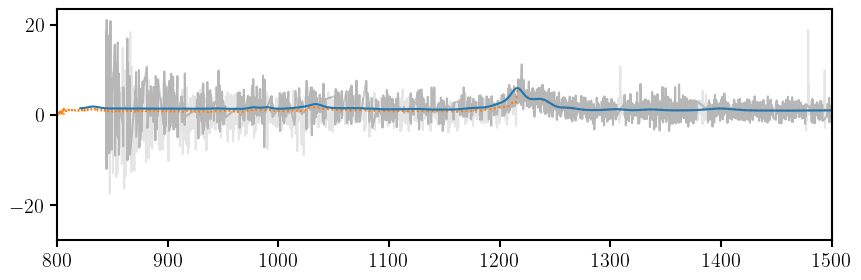

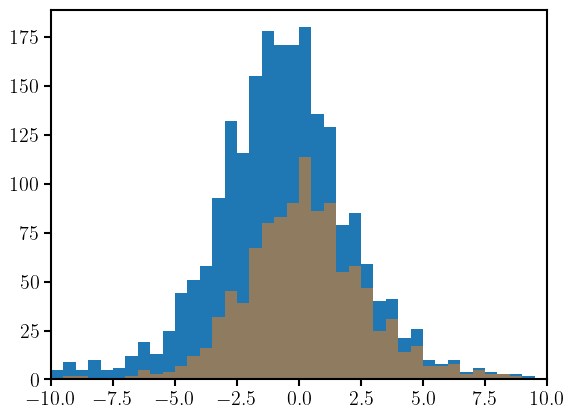

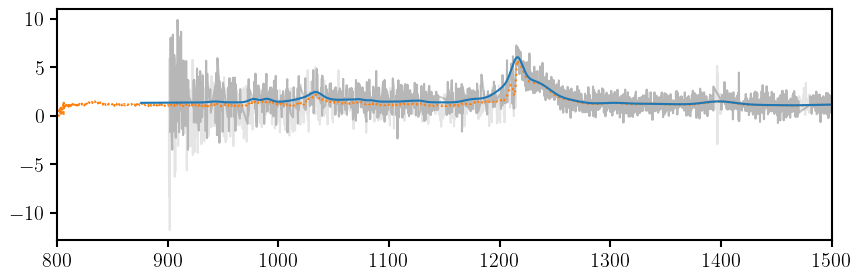

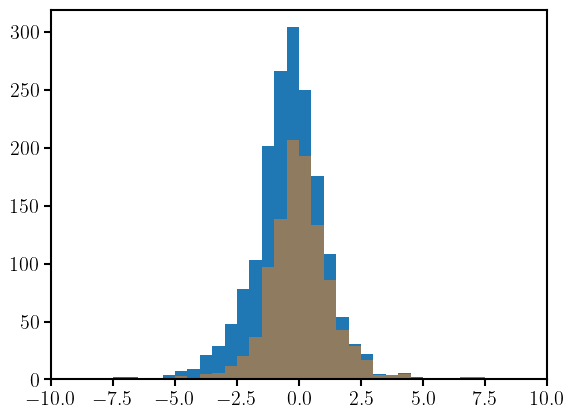

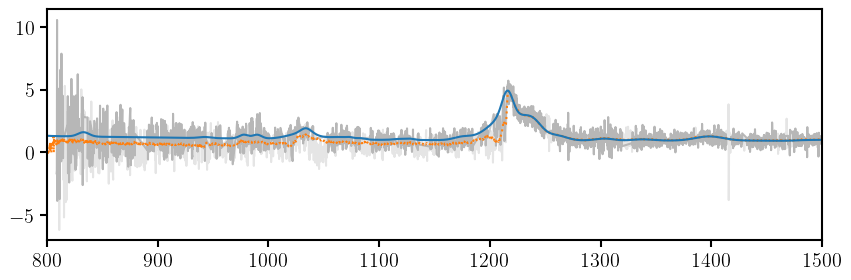

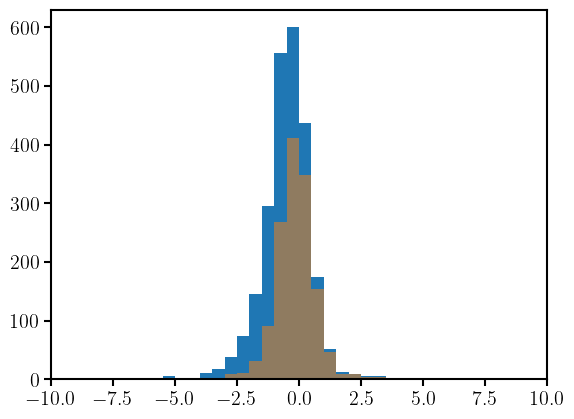

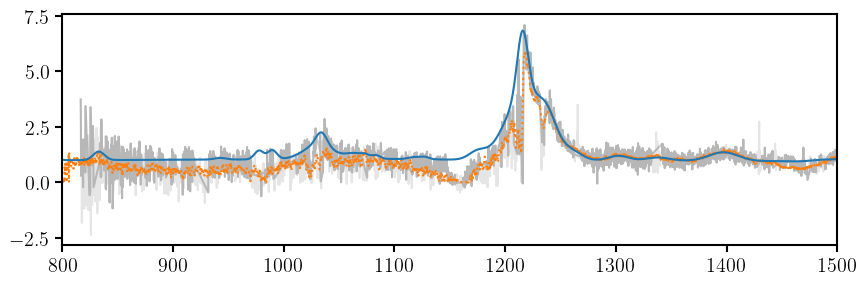

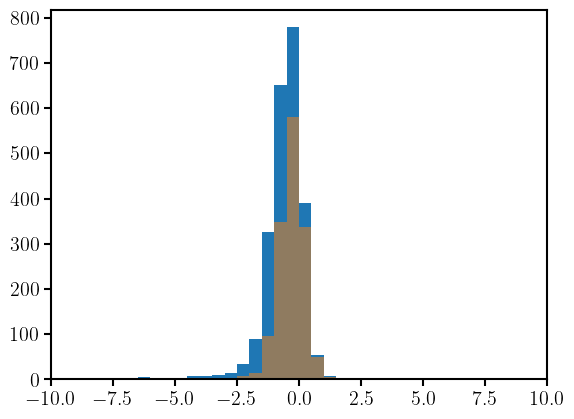

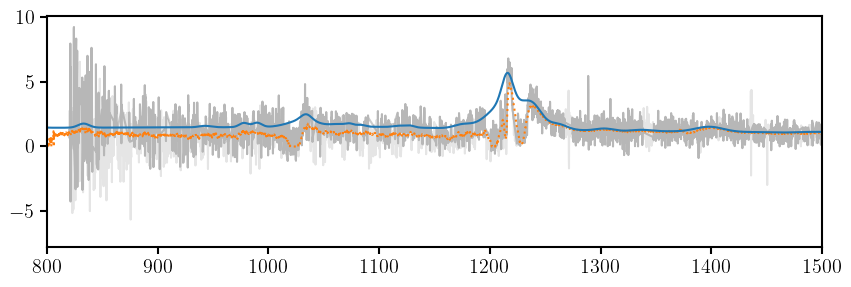

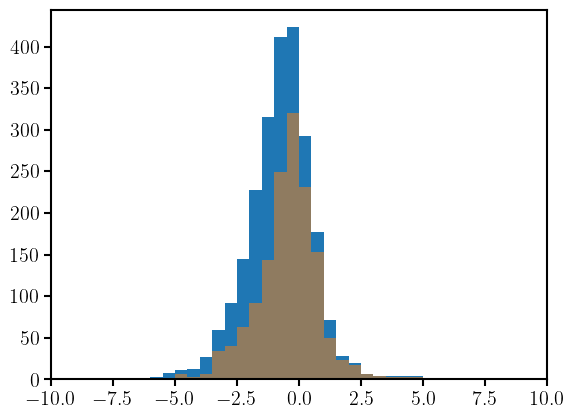

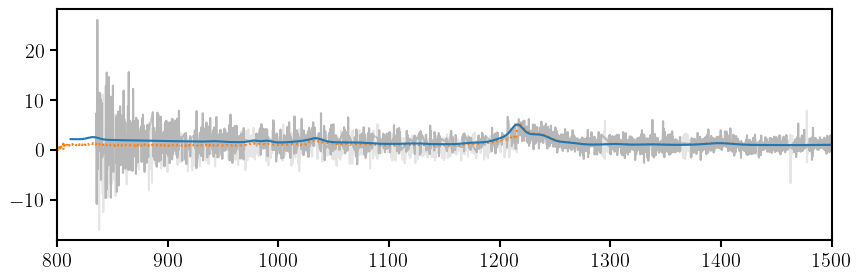

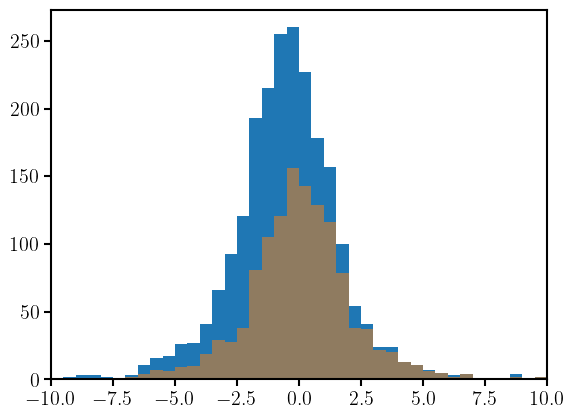

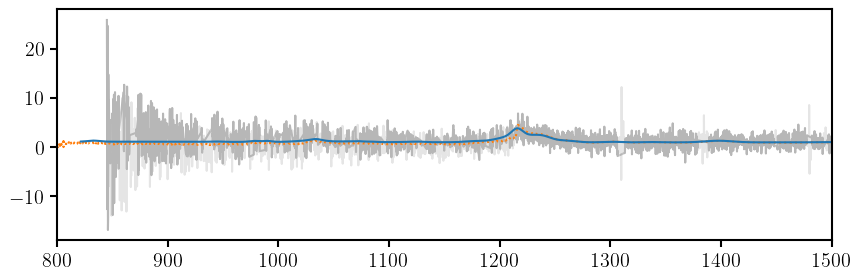

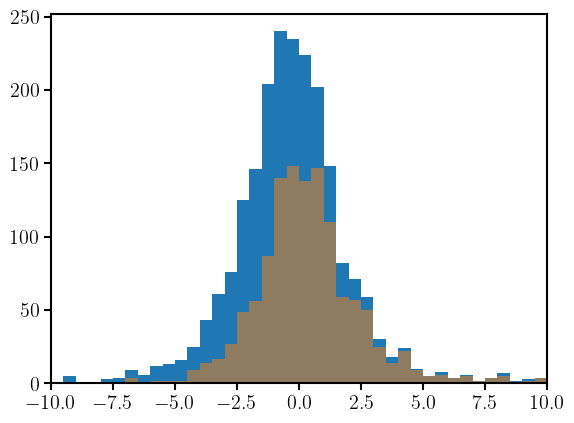

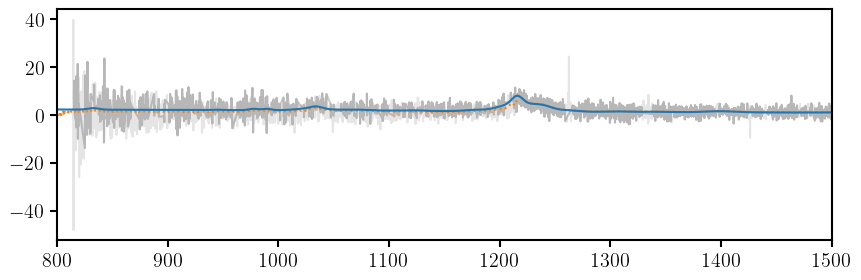

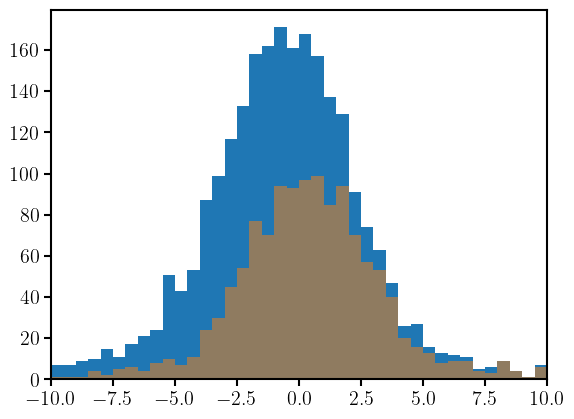

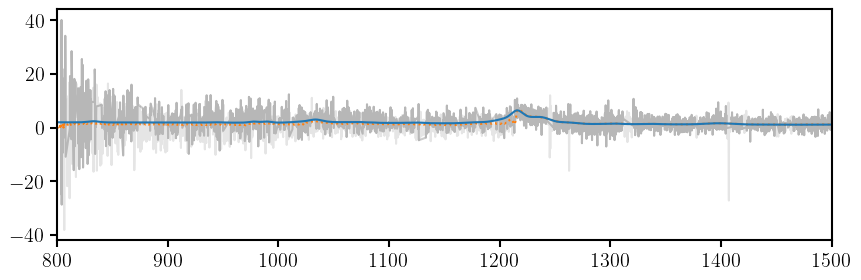

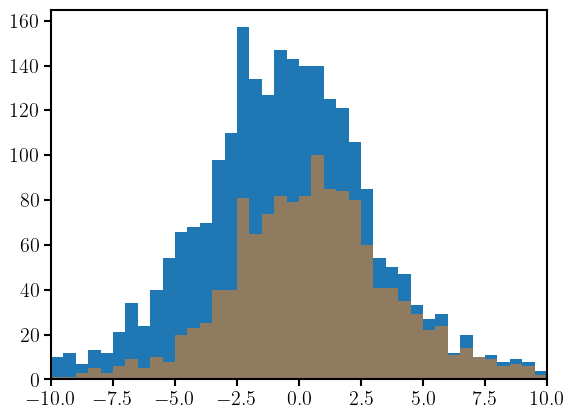

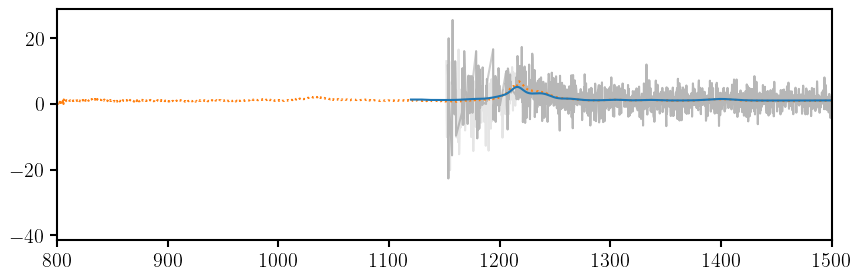

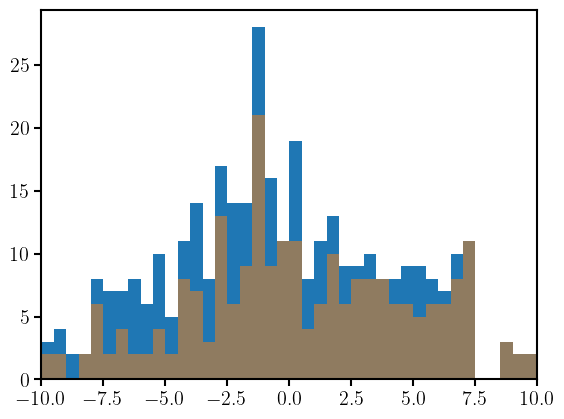

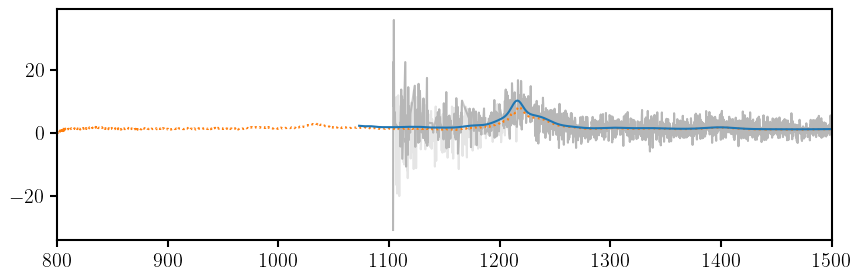

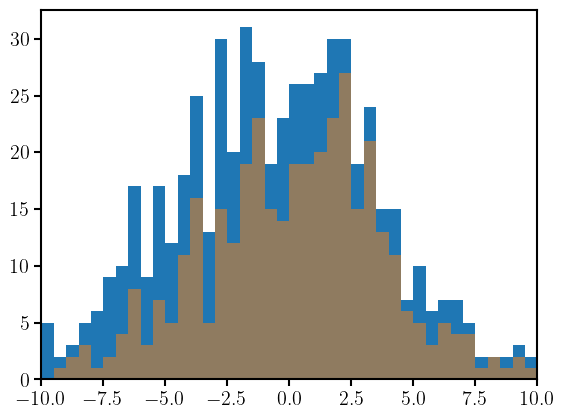

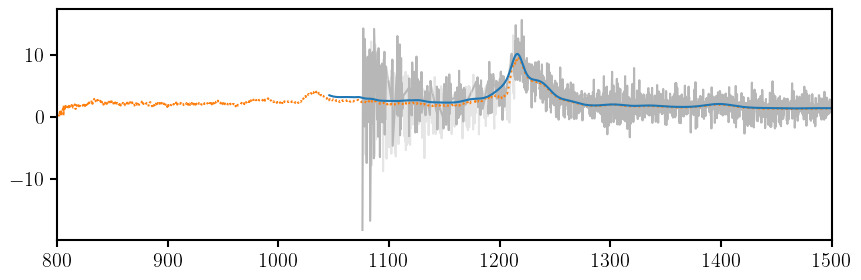

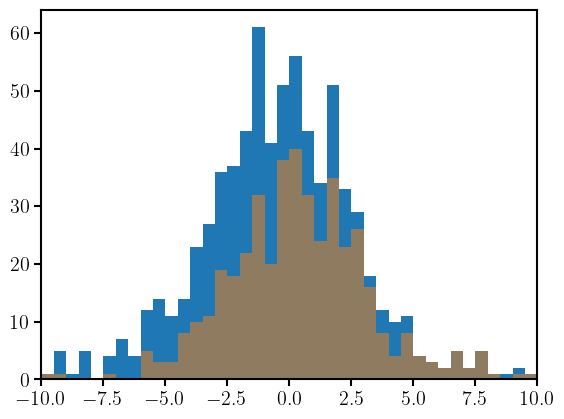

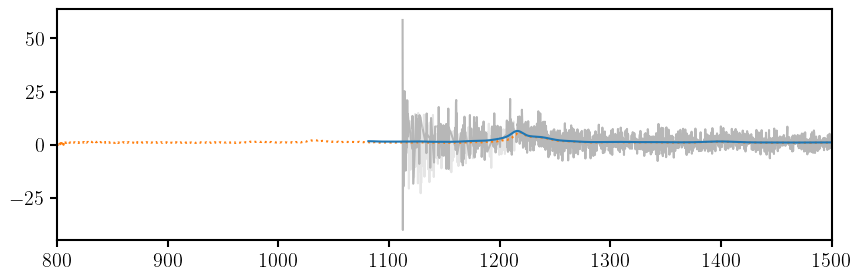

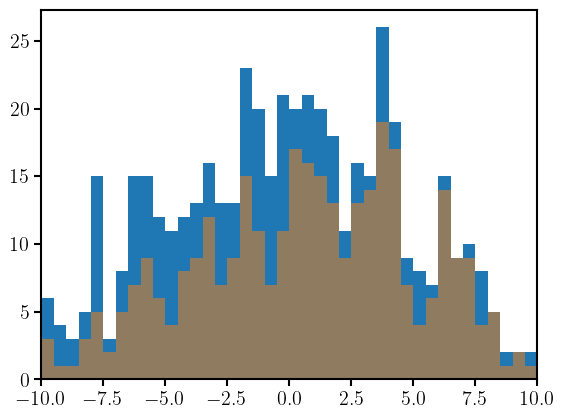

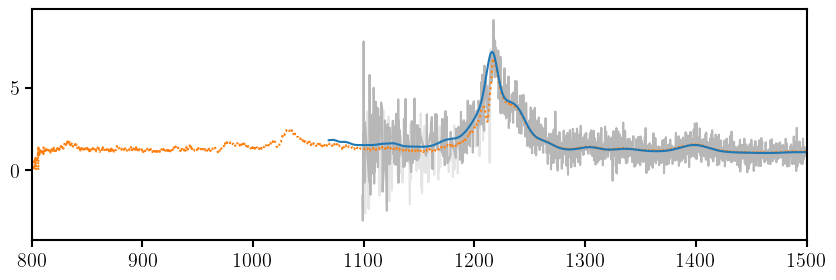

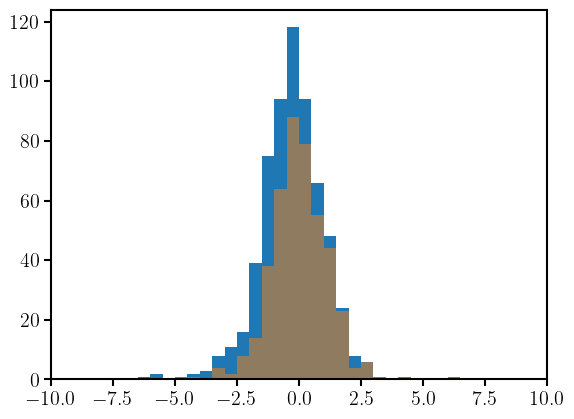

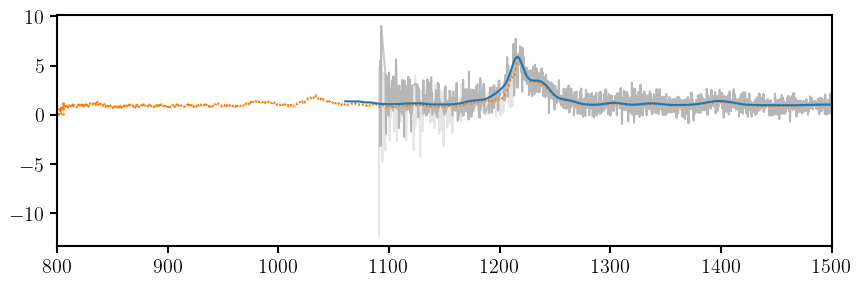

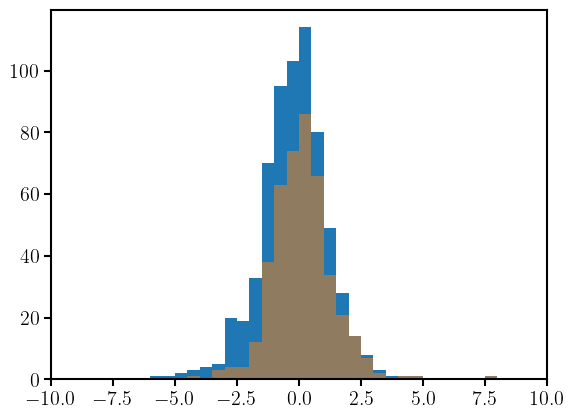

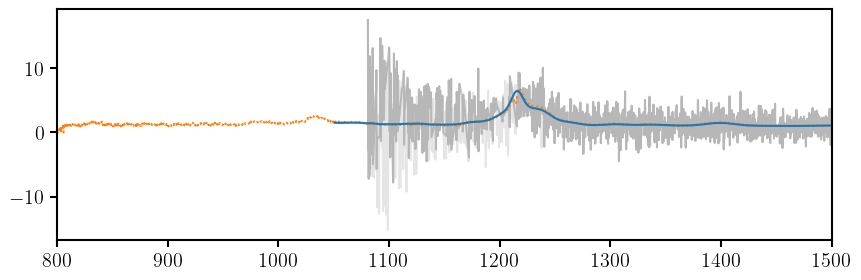

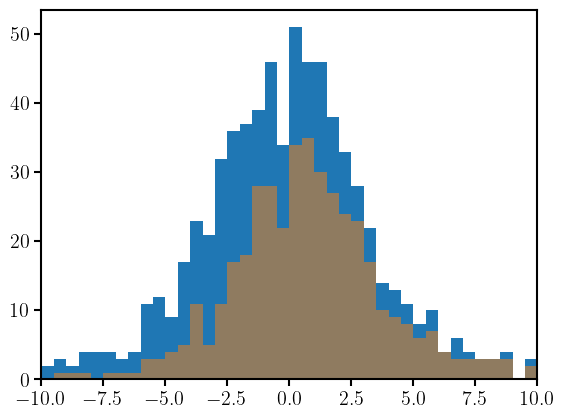

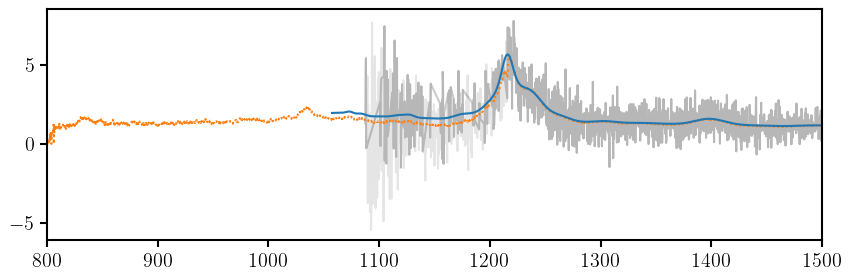

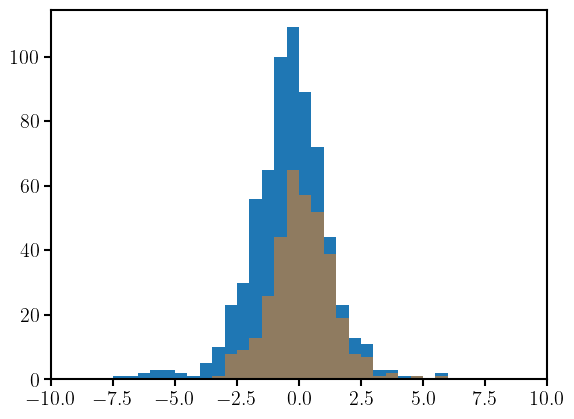

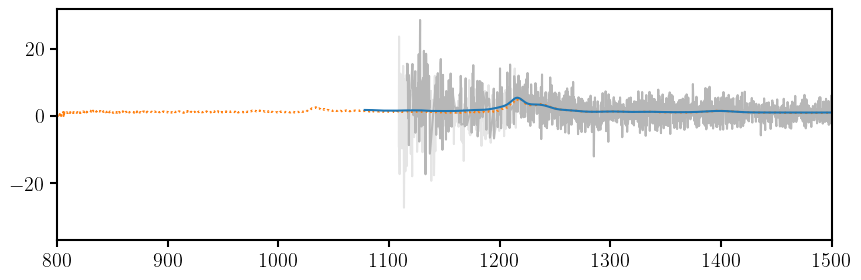

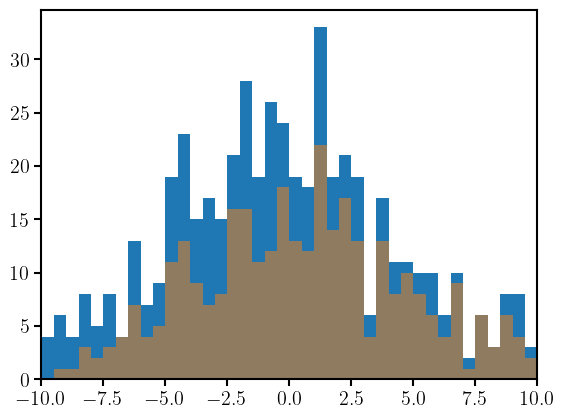

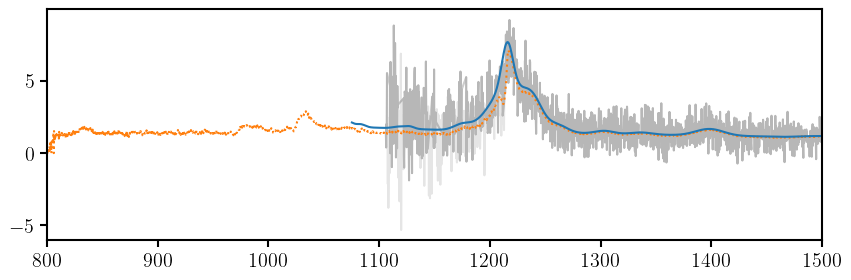

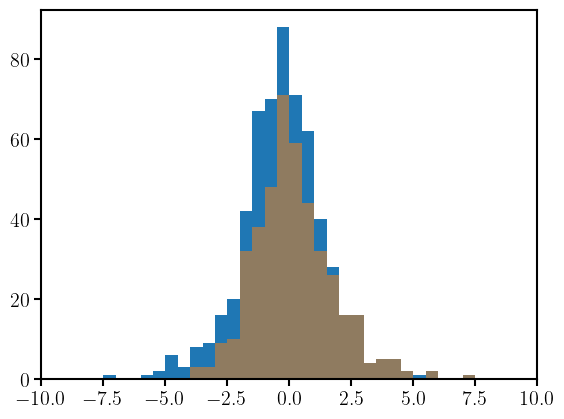

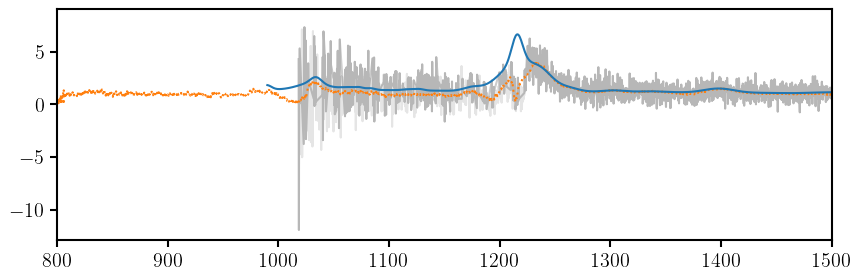

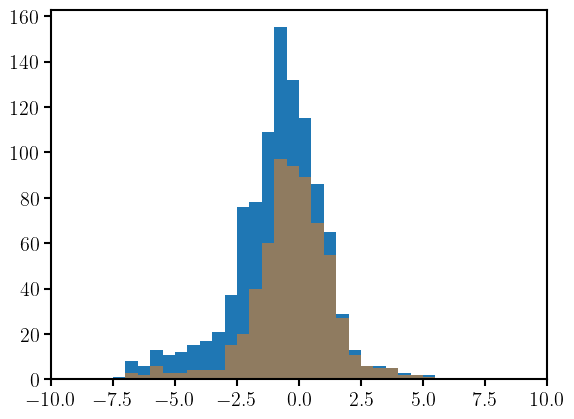

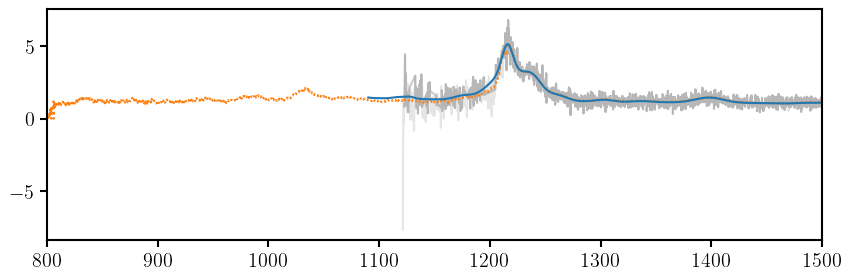

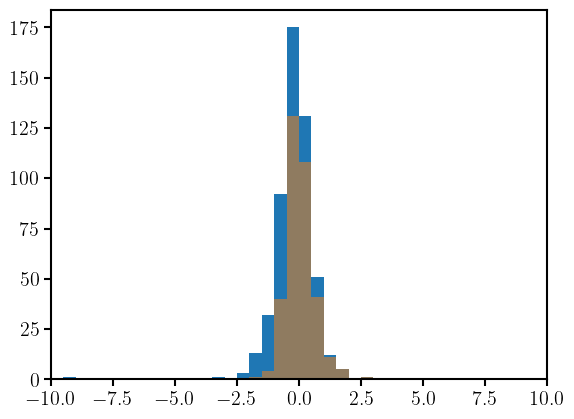

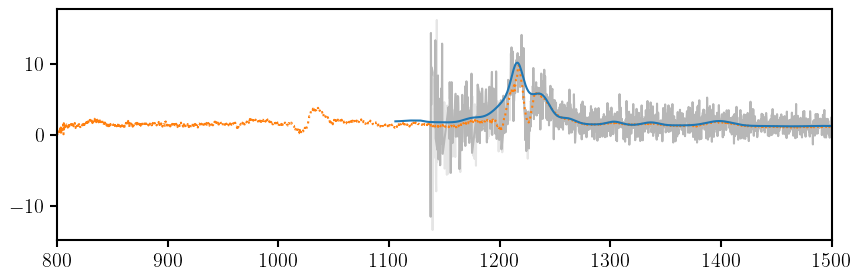

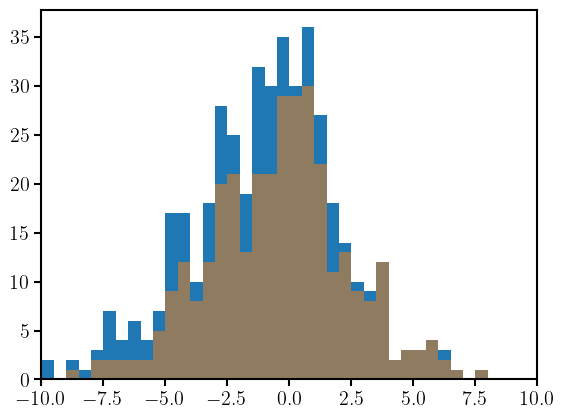

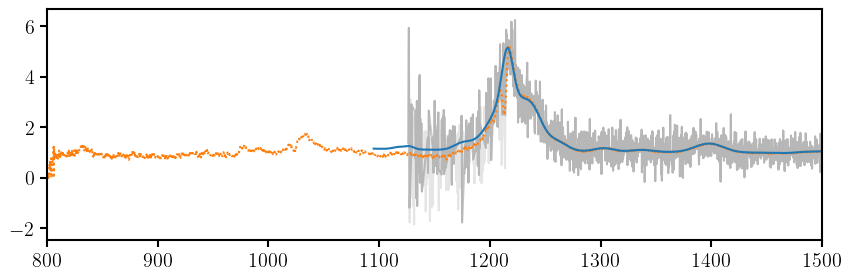

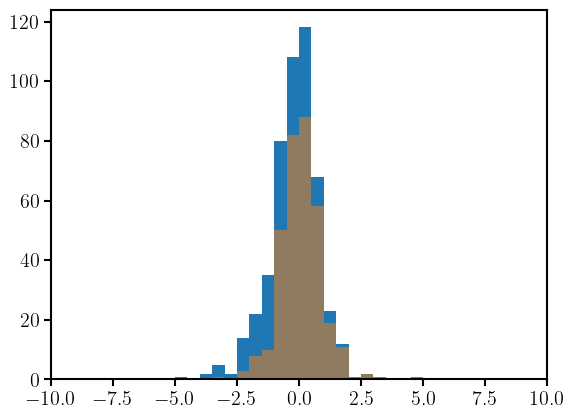

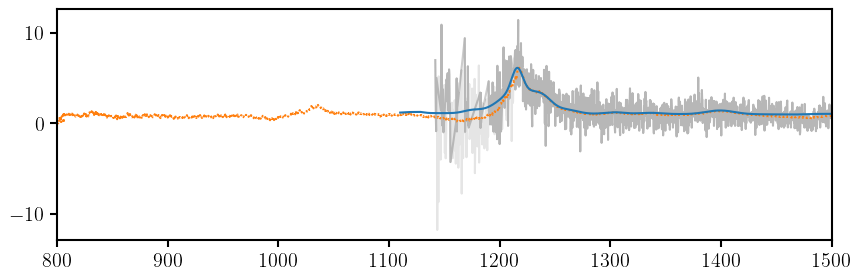

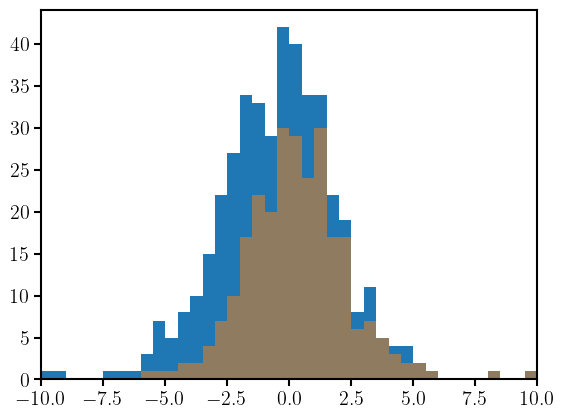

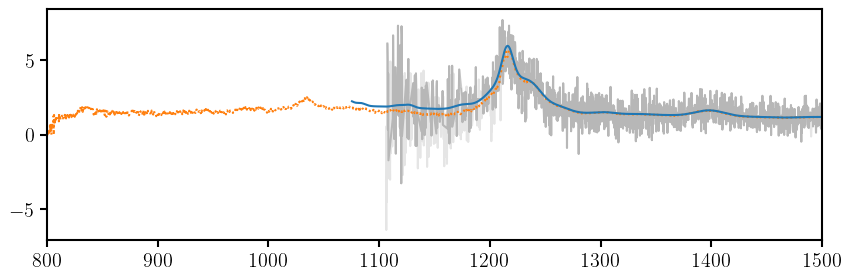

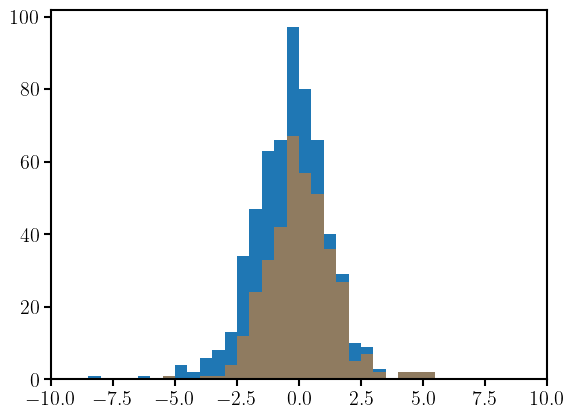

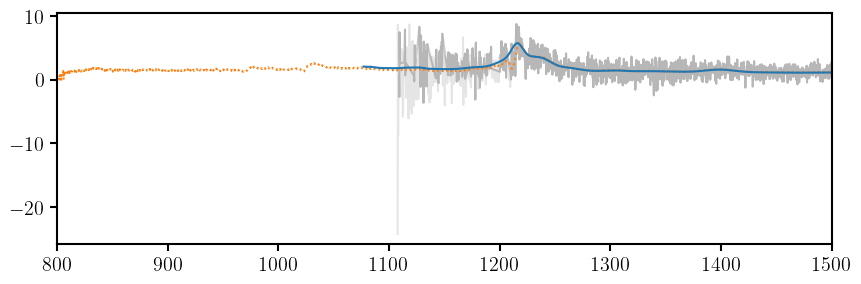

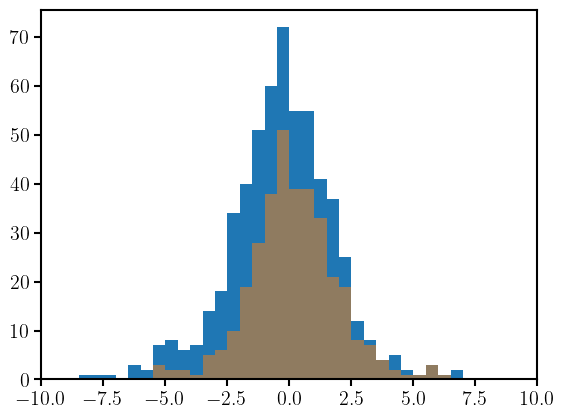

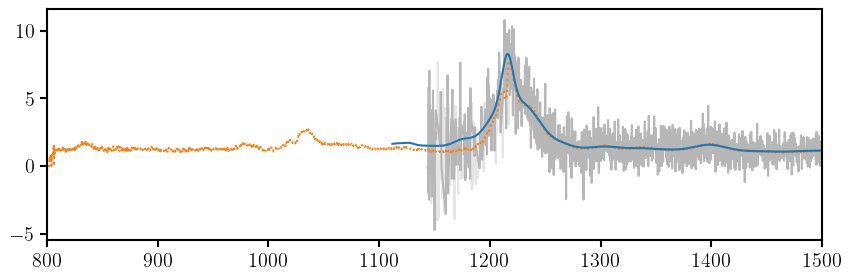

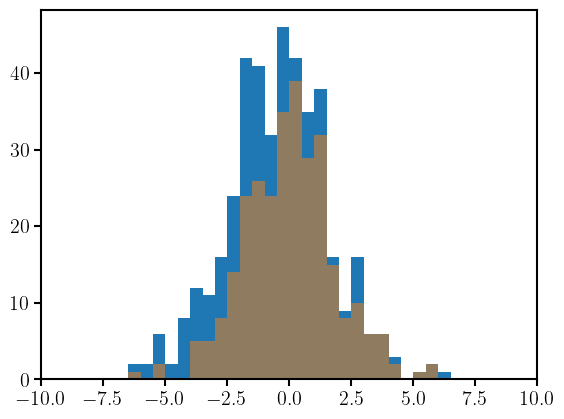

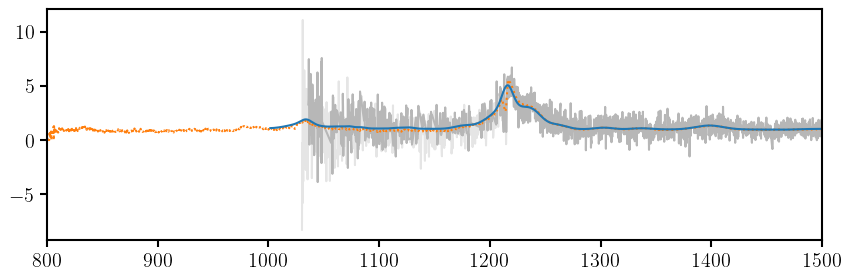

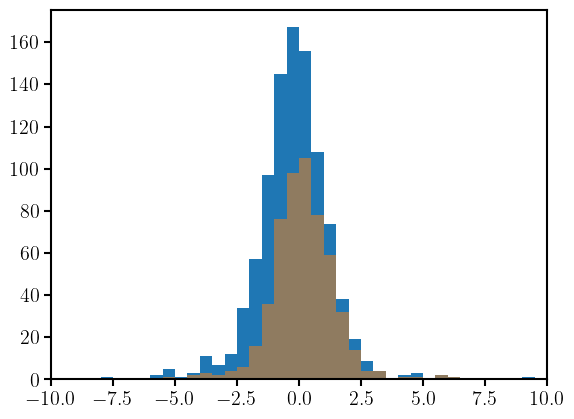

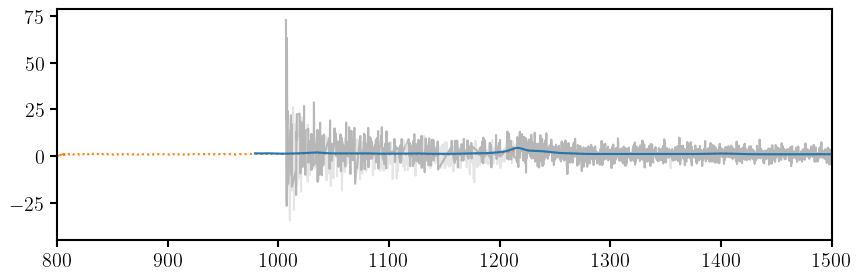

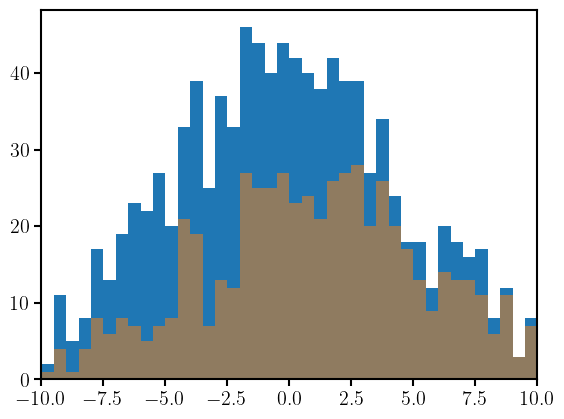

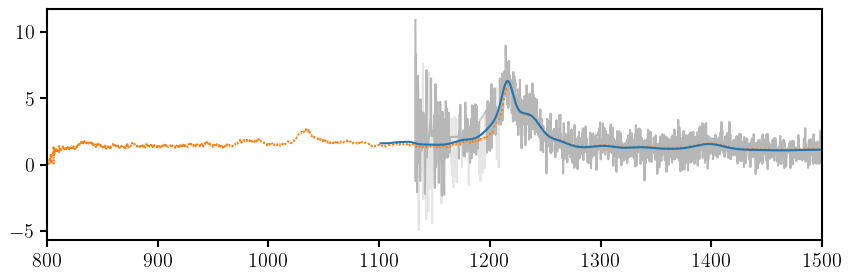

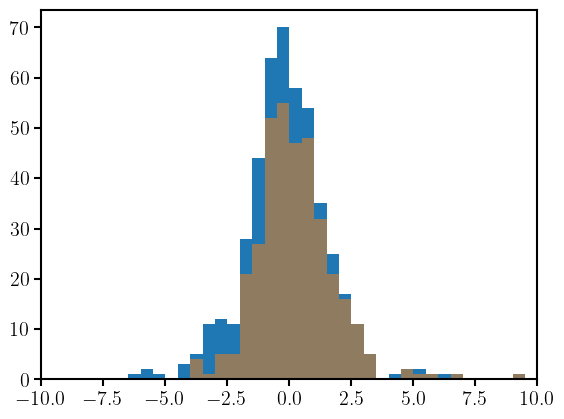

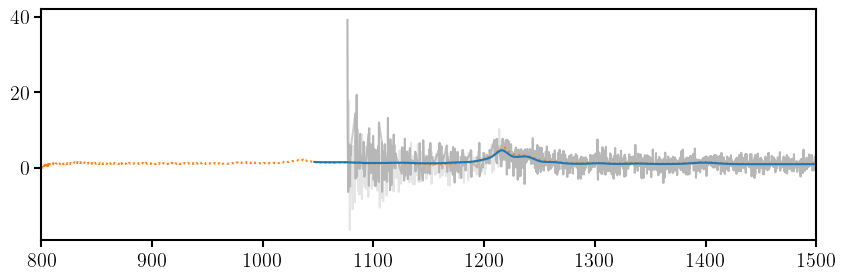

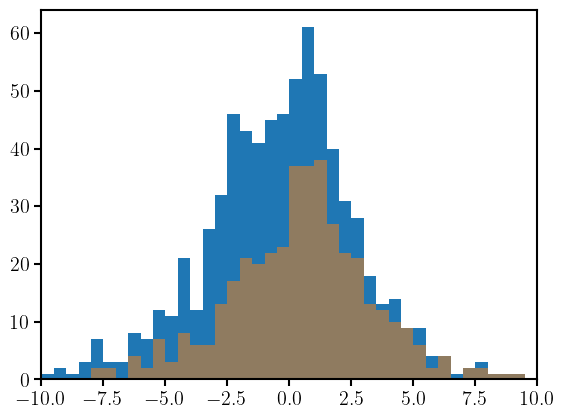

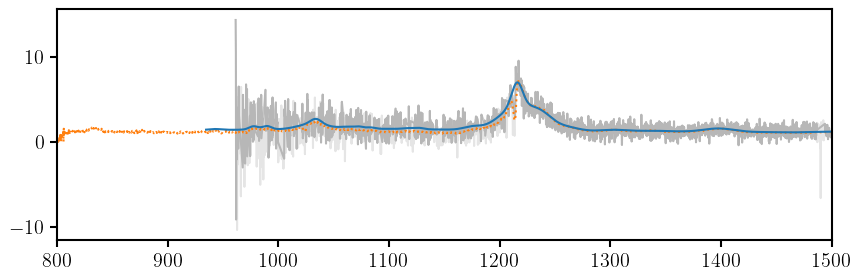

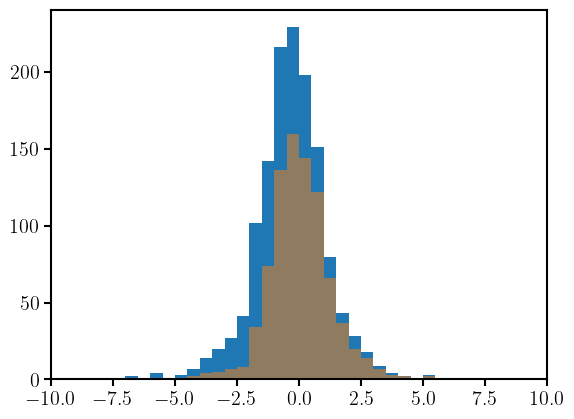

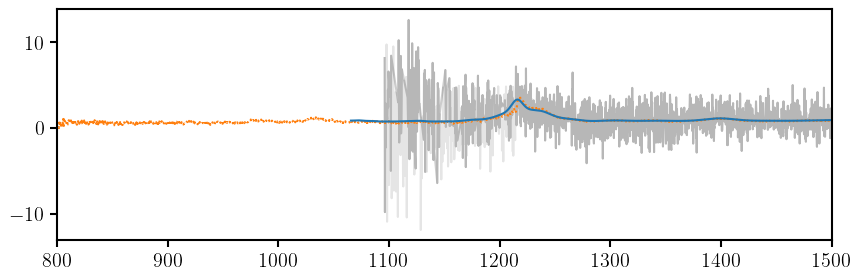

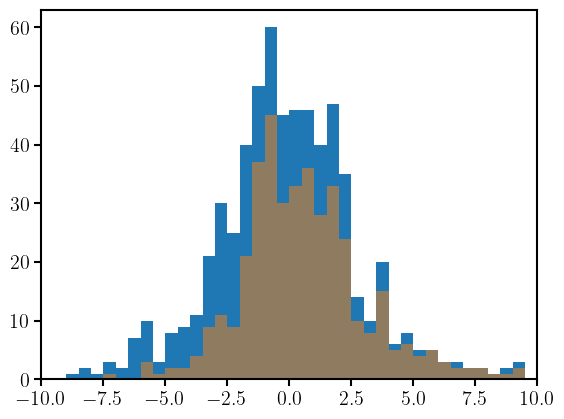

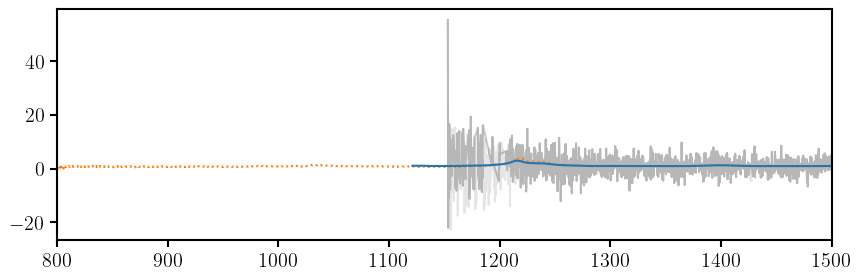

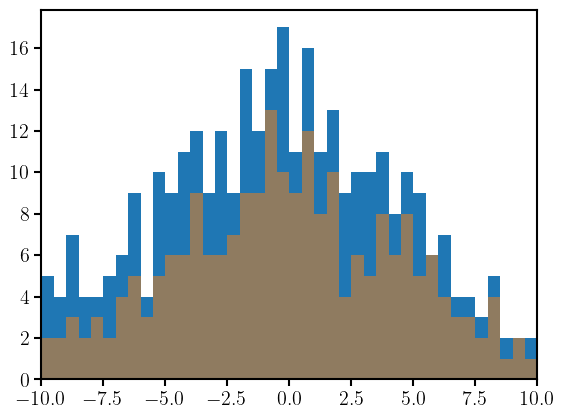

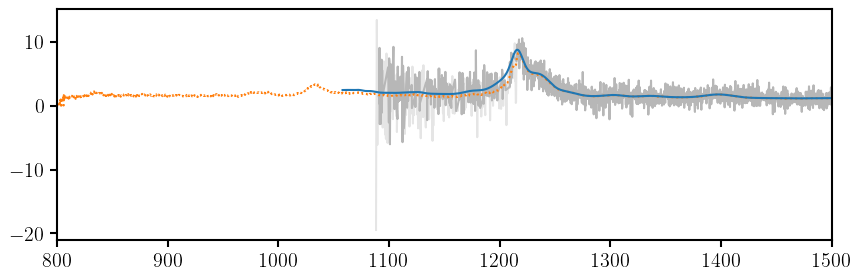

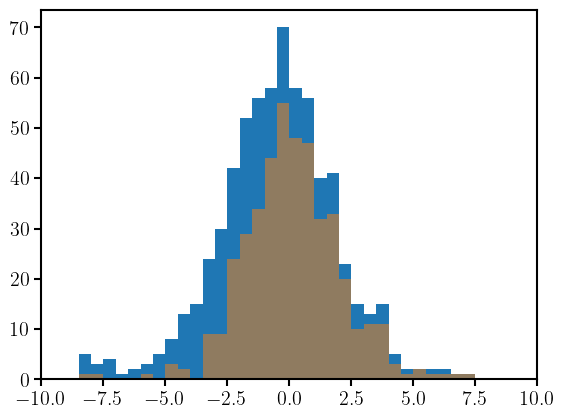

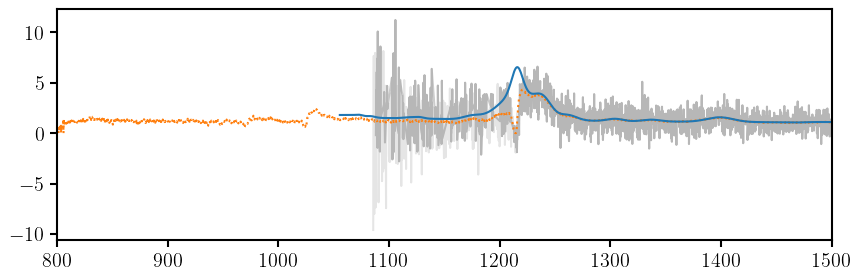

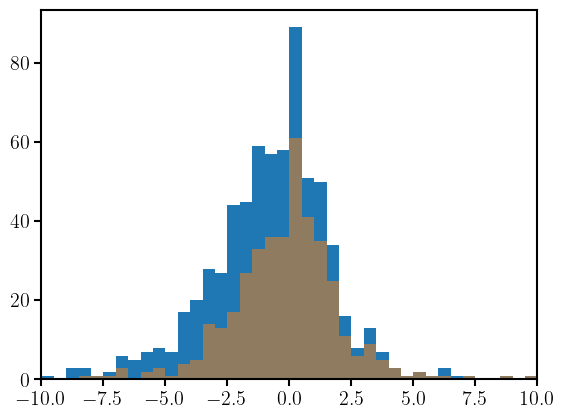

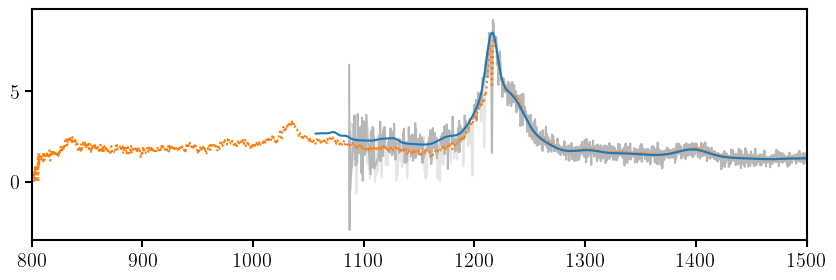

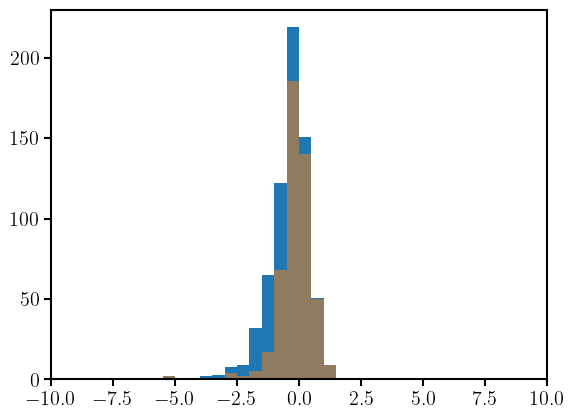

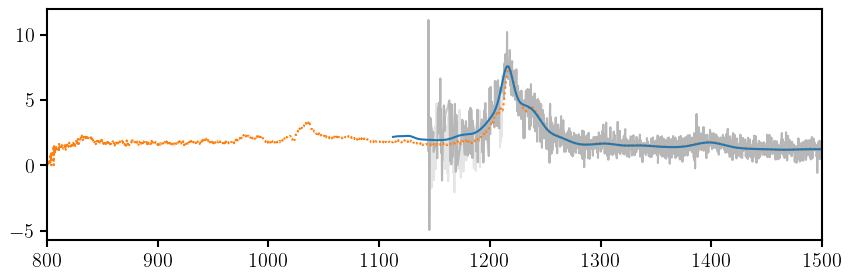

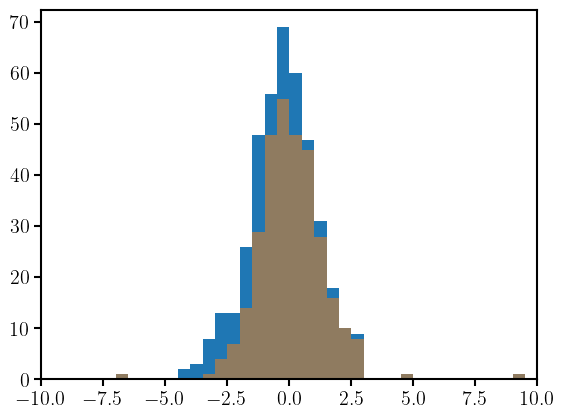

In [43]:
for igal in range(50): 
    fig = plt.figure(figsize=(10,3))
    sub = fig.add_subplot(111)
    
    sub.plot((np.array(models[0].wave_obs)/(1+np.array(z)[igal])), np.array(spec)[igal], c='k', alpha=0.1)
    
    with_w = (w1[igal] > 0.)   
    sub.plot((np.array(models[0].wave_obs)/(1+np.array(z)[igal]))[with_w], np.array(spec)[igal][with_w], c='k', alpha=0.2)
    sub.plot(np.array(models[0].wave_rest), np.array(recon)[igal], c='C1', ls=':')
    sub.plot(np.linspace(3.50e3, 1e4, 3251)/(1+np.array(z)[igal]), np.array(true_cont[igal]/norm[igal]))
    
    sub.set_xlim(800., 1500)

    plt.show()
    
    w_lyab = (np.array(models[0].wave_obs)/(1+np.array(z)[igal])) < 1250
    
    dspec = (np.array(spec)[igal] - np.interp((np.array(models[0].wave_obs)/(1+np.array(z)[igal])), np.linspace(3.50e3, 1e4, 3251)/(1+np.array(z)[igal]), np.array(true_cont[igal]/norm[igal])))
    plt.hist(dspec[w_lyab], range=(-10, 10), bins=40)
    plt.hist(dspec[w_lyab & with_w], range=(-10, 10), bins=40, alpha=0.5)
    plt.xlim(-10, 10)
    #dspec = (np.array(spec)[igal] - np.interp((np.array(models[0].wave_obs)/(1+np.array(z)[igal])), np.linspace(3.50e3, 1e4, 3251)/(1+np.array(z)[igal]), np.array(true_cont[igal]/norm[igal])))*np.array(w)[igal] 
    #plt.hist(dspec[w_lyab], range=(-3, 3), bins=40)
    #plt.hist(dspec[w_lyab & with_w], range=(-3, 3), bins=40, alpha=0.5)
    #plt.xlim(-3, 3)
    plt.show()